### Importem les llibreries necessaries per a la realització del projecte.

In [27]:
import pandas as pd
from pandas import plotting
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
import warnings

# Obviem els warnings per a no sobrecarregar els outputs amb missatges innecessaris
warnings.filterwarnings('ignore')

# 1. Preprocessament de Dades

En aquesta secció, realitzarem el pre-processament de les dades per preparar-les per a la construcció de models de detecció de phishing.

#### <b>1.1 Lectura de Dades</b>


Primer, llegim el conjunt de dades des del fitxer CSV i mostrem les primeres files per entendre la seva estructura.

In [28]:
data = pd.read_csv("dataset_phishing.csv")
data.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


#### <b>1.2 Anàlisi Exploratori de Dades</b>

A continuació, realitzem un anàlisi exploratori de les dades per comprendre millor el conjunt de dades. Això inclou una descripció estadística, la comprovació de valors nuls, la identificació dels tipus de dades, la informació sobre el nombre de files i columnes, i la cerca de files duplicades.

In [ ]:
# Obtenim una descripció completa del dataset.
data.describe([x*0.1 for x in range(10)])

In [ ]:
# Informació sobre el nombre de files i columnes.
data.info()

In [ ]:
# Nombre de valors nuls en cada columna.
data.isnull().sum()

In [ ]:
# Nombre de files duplicades.
data.duplicated().sum()

##### <b>1.2.1 Correlació de caracteristiques</b>

Avaluarem la correlació de cada característica amb la variable objectiu per obtenir un sentit inicial de la seva importància. Les característiques que tenen una correlació molt baixa es poden considerar per a l'eliminació.

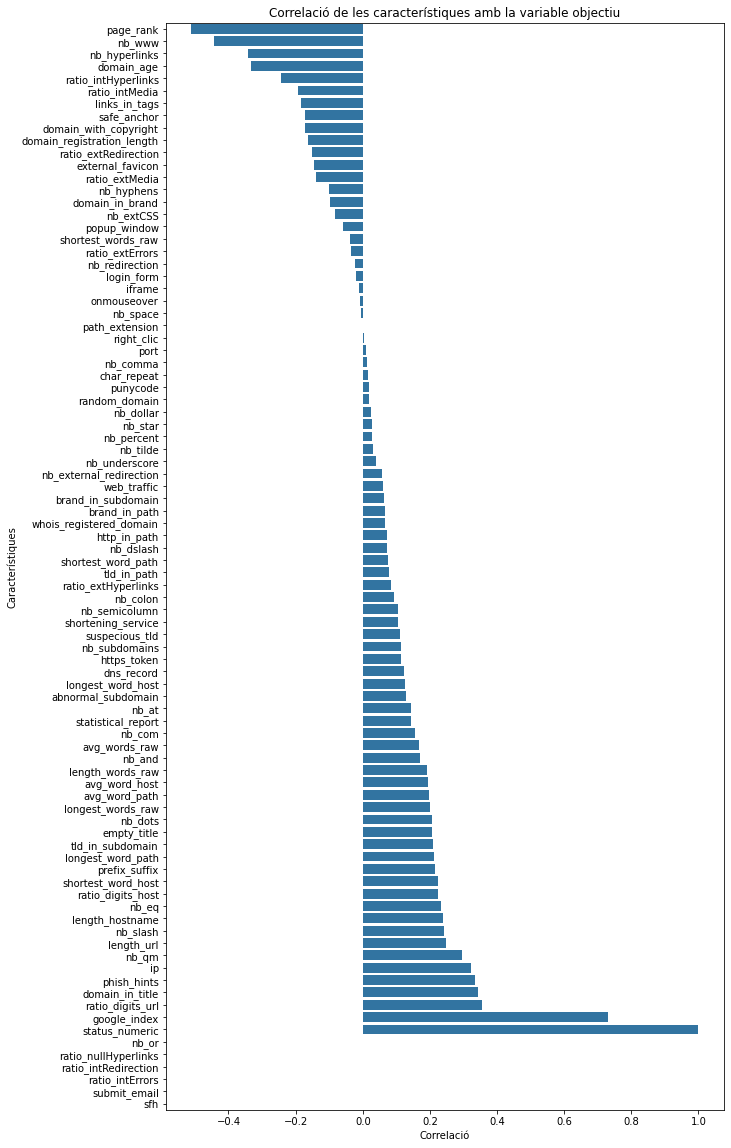

In [29]:
# Convertim la columna 'status' a valors numèrics (1 per a 'phishing' i 0 per a 'legitimate')
data['status_numeric'] = data['status'].apply(lambda x: 1 if x == 'phishing' else 0)

# Calculem la correlació de cada característica amb la columna 'status_numeric'
correlations = data.drop(columns=['url', 'status']).corrwith(data['status_numeric']).sort_values()

# Visualitzem les correlacions
plt.figure(figsize=(10, 20))
sns.barplot(x=correlations, y=correlations.index)
plt.title('Correlació de les característiques amb la variable objectiu')
plt.xlabel('Correlació')
plt.ylabel('Característiques')
plt.show()

A partir del diagrama de correlació, podem veure com cada característica es correlaciona amb la variable de destinació. 

Important:

    · Una correlació propera a 1 indica una forta relació positiva.
    · Una correlació propera a -1 indica una forta relació negativa.
    · Una correlació propera a 0 indica poca o cap relació.

Basant-nos en això, podríem considerar eliminar característiques que tenen una correlació molt propera a 0, ja que podrien no contribuir molt al poder predictiu d'un model. No obstant això, els mantindrem de moment i podríem revisar aquesta decisió després de l'avaluació del model.

#### <b>1.3 Manipulació de Dades</b>

En aquesta secció, realitzem les següents etapes de pre-processament de dades:

En primer lloc, haurem de guardar en una nova variable el conjunt de dades original per a poder fer modificacions sobre aquesta.

In [30]:
data_preprocessada = data

Eliminarem la columna "url" ja que és única per a cada fila i no aportarà informació útil per al model de classificació. En aquest cas, estem simplificant el conjunt de dades eliminant una característica que no és rellevant per a la nostra anàlisi. També eliminarem la columna creada anteriorment "status_numeric" ja que si no la eliminem, el model de classificació podria sobreajustar-se a aquesta característica tot i obtenint una accuracy de 1, ja que la columna "status" i "status_numeric" són equivalents amb una correlació del 100%.

In [31]:
data_preprocessada = data_preprocessada.drop(columns=['url', 'status_numeric'])
data_preprocessada.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,77,23,1,1,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,126,50,1,4,1,0,1,2,0,3,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,18,11,0,2,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,55,15,0,2,2,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


##### <b>1.3.1 Tractament de Valors Nuls</b>

· Per a les <b>columnes numèriques</b>, substituïm els valors nuls per la mitjana de la columna. <br>
· Per a les <b>columnes categòriques</b>, substituïm els valors nuls pel valor més freqüent de la columna.

In [32]:
# Tractament de valors nuls
for column in data_preprocessada.select_dtypes(include=['int', 'float']).columns:
    data_preprocessada[column].fillna(data_preprocessada[column].mean(), inplace=True)

for column in data_preprocessada.select_dtypes(include=['object']).columns:
    data_preprocessada[column].fillna(data_preprocessada[column].mode()[0], inplace=True)

##### <b>1.3.2 Eliminar columnes Redundants</b>

Simplificarem el conjunt de dades. 
Analitzem si hi ha alguna columna que pugui ser redundant o no útil per a la nostra anàlisi. 
Revisem les estadístiques descriptives de les columnes per veure si alguna d'elles presenta variància zero o valors constants, ja que aquestes columnes no aportarien informació útil per a la majoria d'algorismes.

In [33]:
# Obtenim les estadistiques de les columnes numeriques.
desc_stats = data_preprocessada.describe()

# Identifiquem les columnes amb 0 variança (desviació estàndard igual a zero)
zero_variance_columns = desc_stats.columns[desc_stats.loc["std"] == 0]

zero_variance_columns

Index(['nb_or', 'ratio_nullHyperlinks', 'ratio_intRedirection',
       'ratio_intErrors', 'submit_email', 'sfh'],
      dtype='object')

Les columnes següents presenten variància zero, la qual cosa significa que tenen el mateix valor en totes les files:

    · nb_or
    · ratio_nullHyperlinks
    · ratio_intRedirection
    · ratio_intErrors
    · submit_email
    · sfh
    
Aquestes columnes poden ser considerades com a redundants ja que no aporten informació variable al nostre model. Per tant, es recomana eliminar-les del conjunt de dades.

A continuació, procedirem a eliminar aquestes columnes del conjunt de dades.​

In [34]:
# Remove the zero variance columns from the dataset
data_preprocessada = data_preprocessada.drop(columns=zero_variance_columns)

# Display the first few rows of the cleaned dataset
data_preprocessada.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_eq,nb_underscore,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,77,23,1,1,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,126,50,1,4,1,0,1,2,3,2,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,18,11,0,2,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,55,15,0,2,2,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


##### <b>1.3.3 Conversió de Dades Categòriques a Dades Numèriques</b>

· Utilitzem <b>LabelEncoder</b> per transformar les columnes categòriques en dades numèriques.

In [35]:
# Conversió de dades categòriques a numèriques
le = LabelEncoder()
for column in data_preprocessada.columns:
    if data_preprocessada[column].dtype == type(object):
        data_preprocessada[column] = le.fit_transform(data_preprocessada[column])

##### <b>1.3.4 Normalització de Dades Numèriques</b>

Normalitzem les dades numèriques en un rang de 0 a 1.

In [36]:
# Normalització de dades numèriques
for column in data_preprocessada.columns:
    if data_preprocessada[column].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        data_preprocessada[column] = (data_preprocessada[column] - data_preprocessada[column].min()) / (data_preprocessada[column].max() - data_preprocessada[column].min())

Ara que les dades han estat pre-processades, estan llestes per ser utilitzades per a la construcció i avaluació de models de detecció de phishing.

In [37]:
# Dades pre-processades
data_preprocessada.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_eq,nb_underscore,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,0.015347,0.071429,0.0,0.086957,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.001542,0.000854,0.000000,1.0,1.0,0.4,0.0
1,0.039902,0.090476,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,0.002615,0.448471,0.000000,0.0,1.0,0.2,1.0
2,0.069982,0.219048,1.0,0.130435,0.023256,0.0,0.333333,0.105263,0.157895,0.111111,...,1.0,0.0,0.0,0.000503,0.311656,0.541310,0.0,1.0,0.0,1.0
3,0.003683,0.033333,0.0,0.043478,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,0.002112,0.000854,0.010004,0.0,0.0,0.3,0.0
4,0.026397,0.052381,0.0,0.043478,0.046512,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.007543,0.635341,0.000810,0.0,0.0,0.6,0.0


#### <b>1.4 Histogrames i Boxplot</b>

Crearem gràfics de caixes (boxplots) i histogrames per visualitzar la distribució de les característiques numèriques en el conjunt de dades pre-processades i originals. Aquests gràfics ens ajudaran a entendre millor com es distribueixen les dades i a identificar valors extrems (outliers).

##### <b>1.4.1 Gràfics de Caixes (Boxplots)</b>

Els gràfics de caixes són útils per representar visualment la distribució i la variabilitat de les dades numèriques. Ens mostren la mediana, els quartils i els valors extrems

<b>· Dades originals</b>

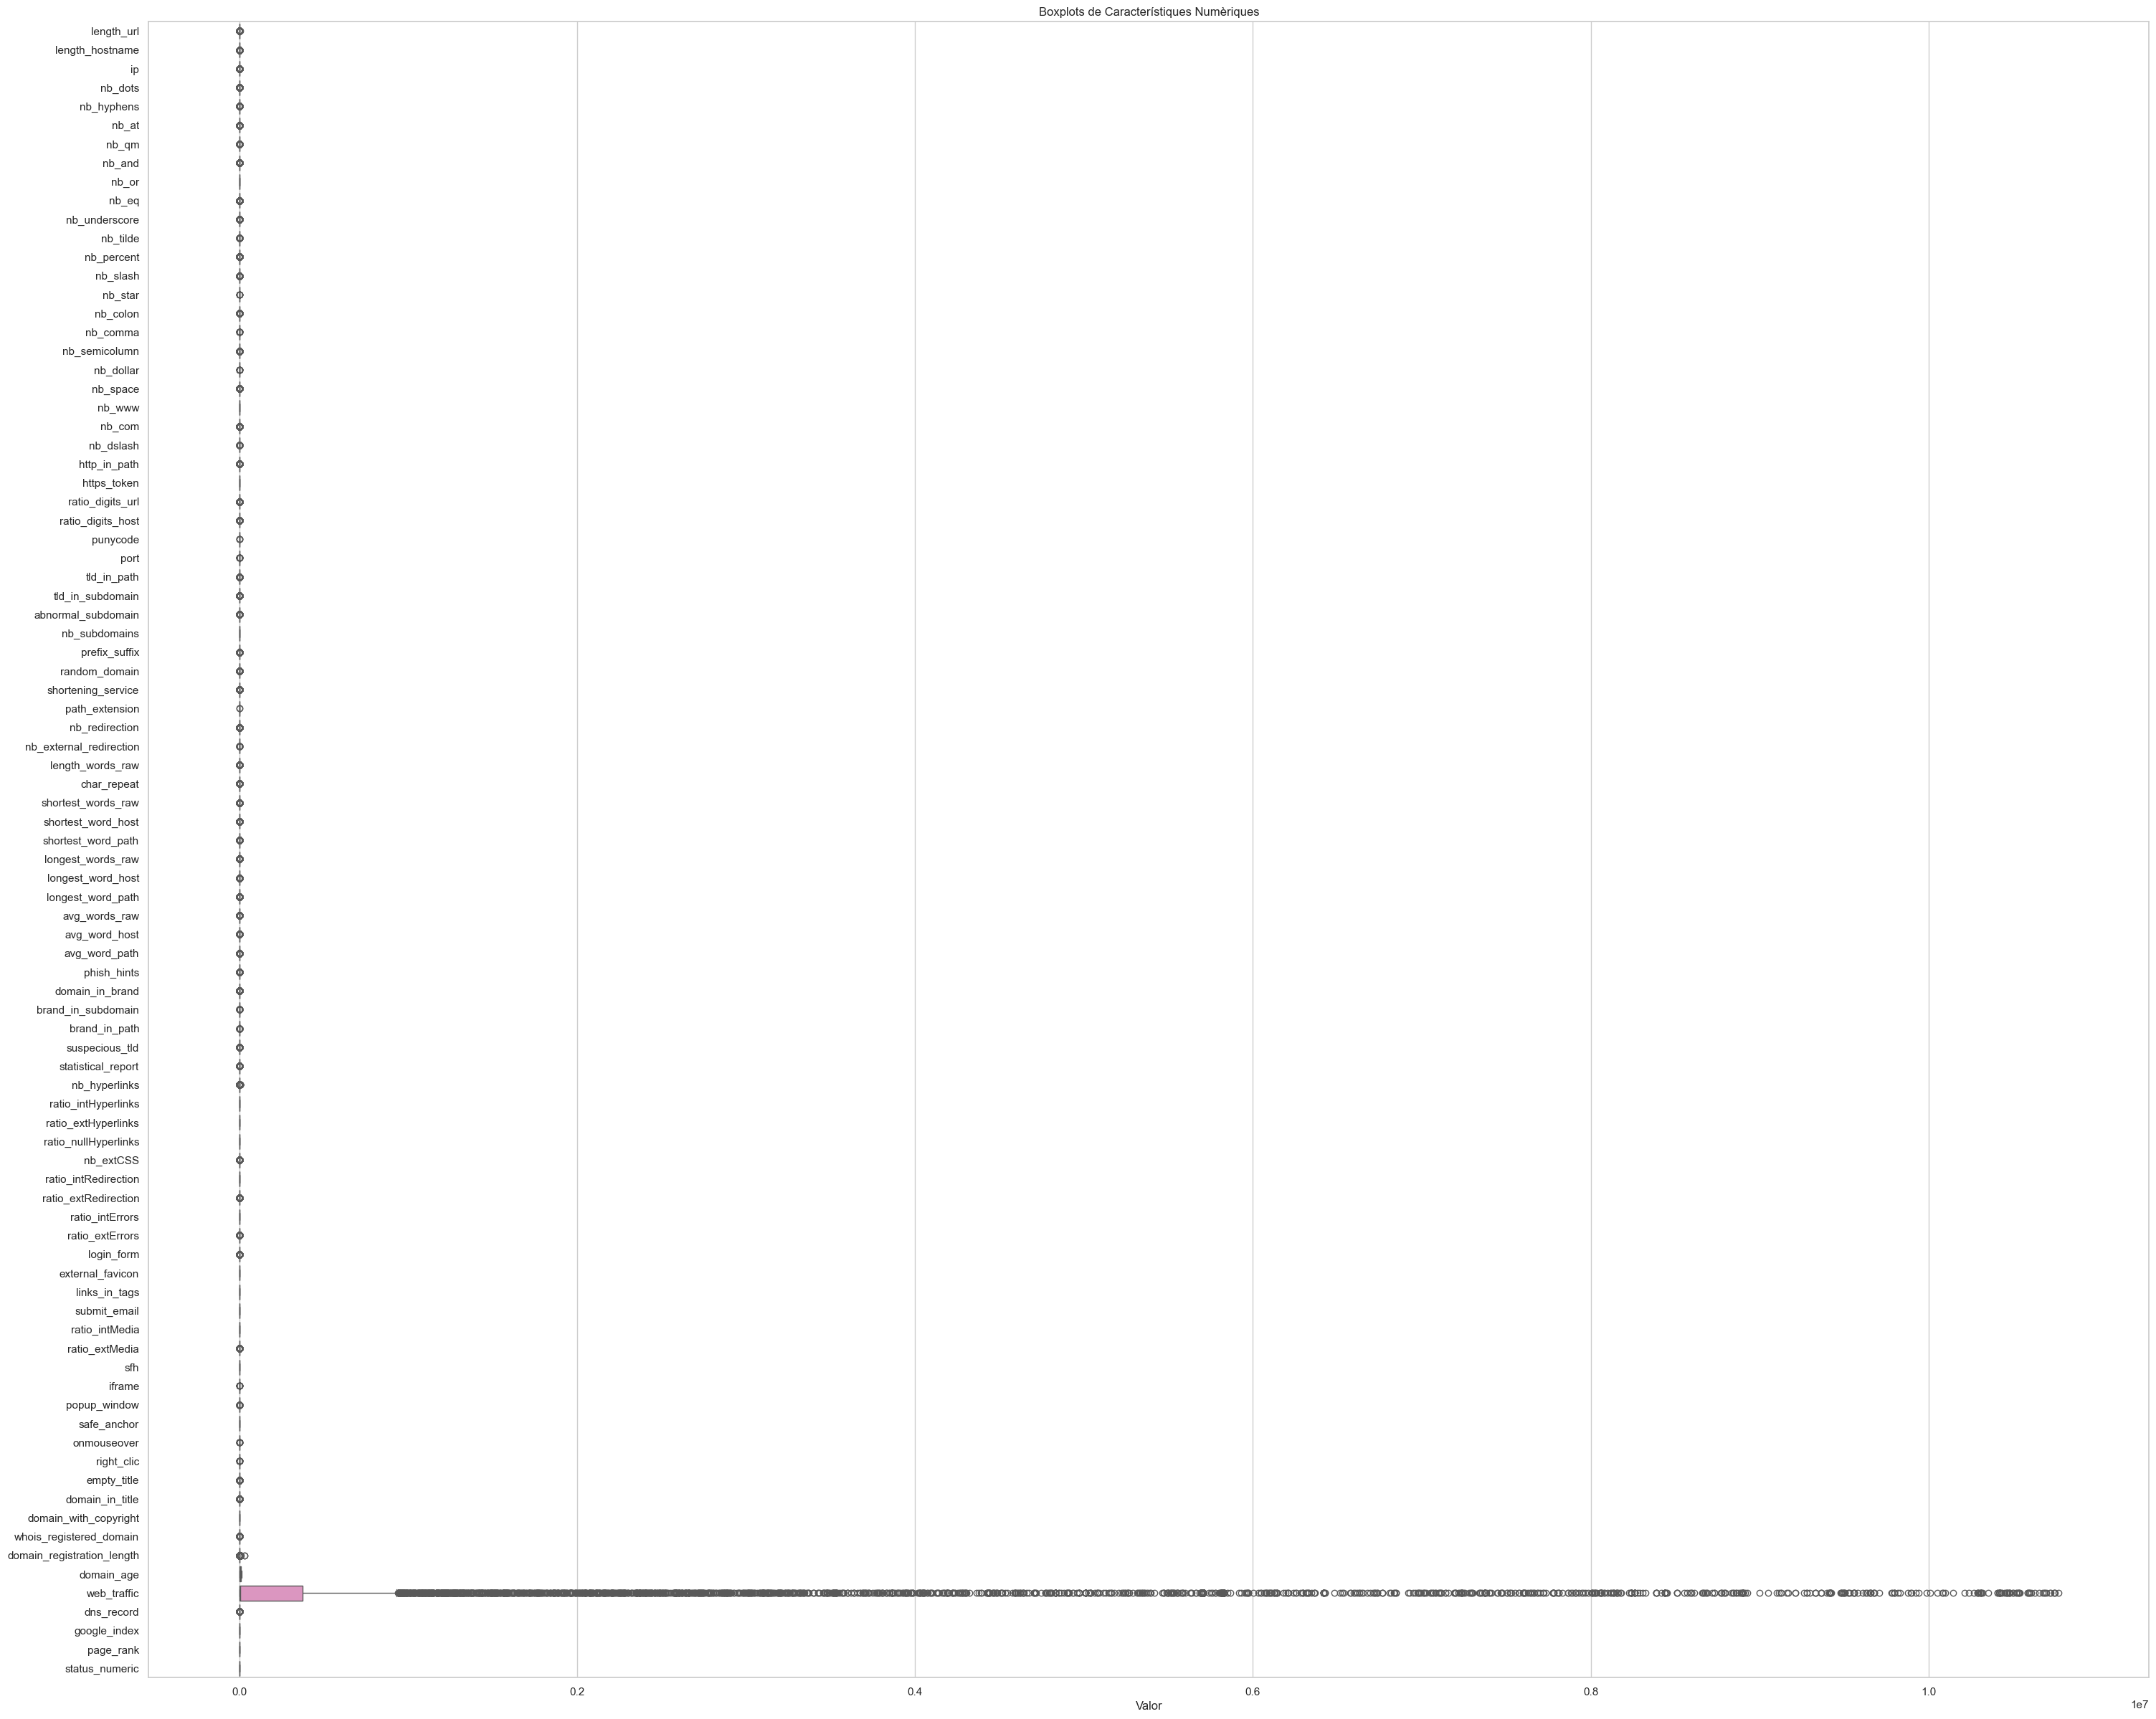

In [70]:
# Creació de gràfics de caixes més grans per a característiques numèriques
plt.figure(figsize=(36, 30)) 
sns.set(style="whitegrid")

# Seleccionem les característiques numèriques per als quals volem generar els boxplots
features_for_boxplot = data.select_dtypes(include=['int', 'float'])

# Dibuixem els gràfics de caixes
sns.boxplot(data=features_for_boxplot, orient="h", palette="Set2")
plt.title("Boxplots de Característiques Numèriques")
plt.xlabel("Valor")
plt.show()

<b>· Dades pre-processades</b>

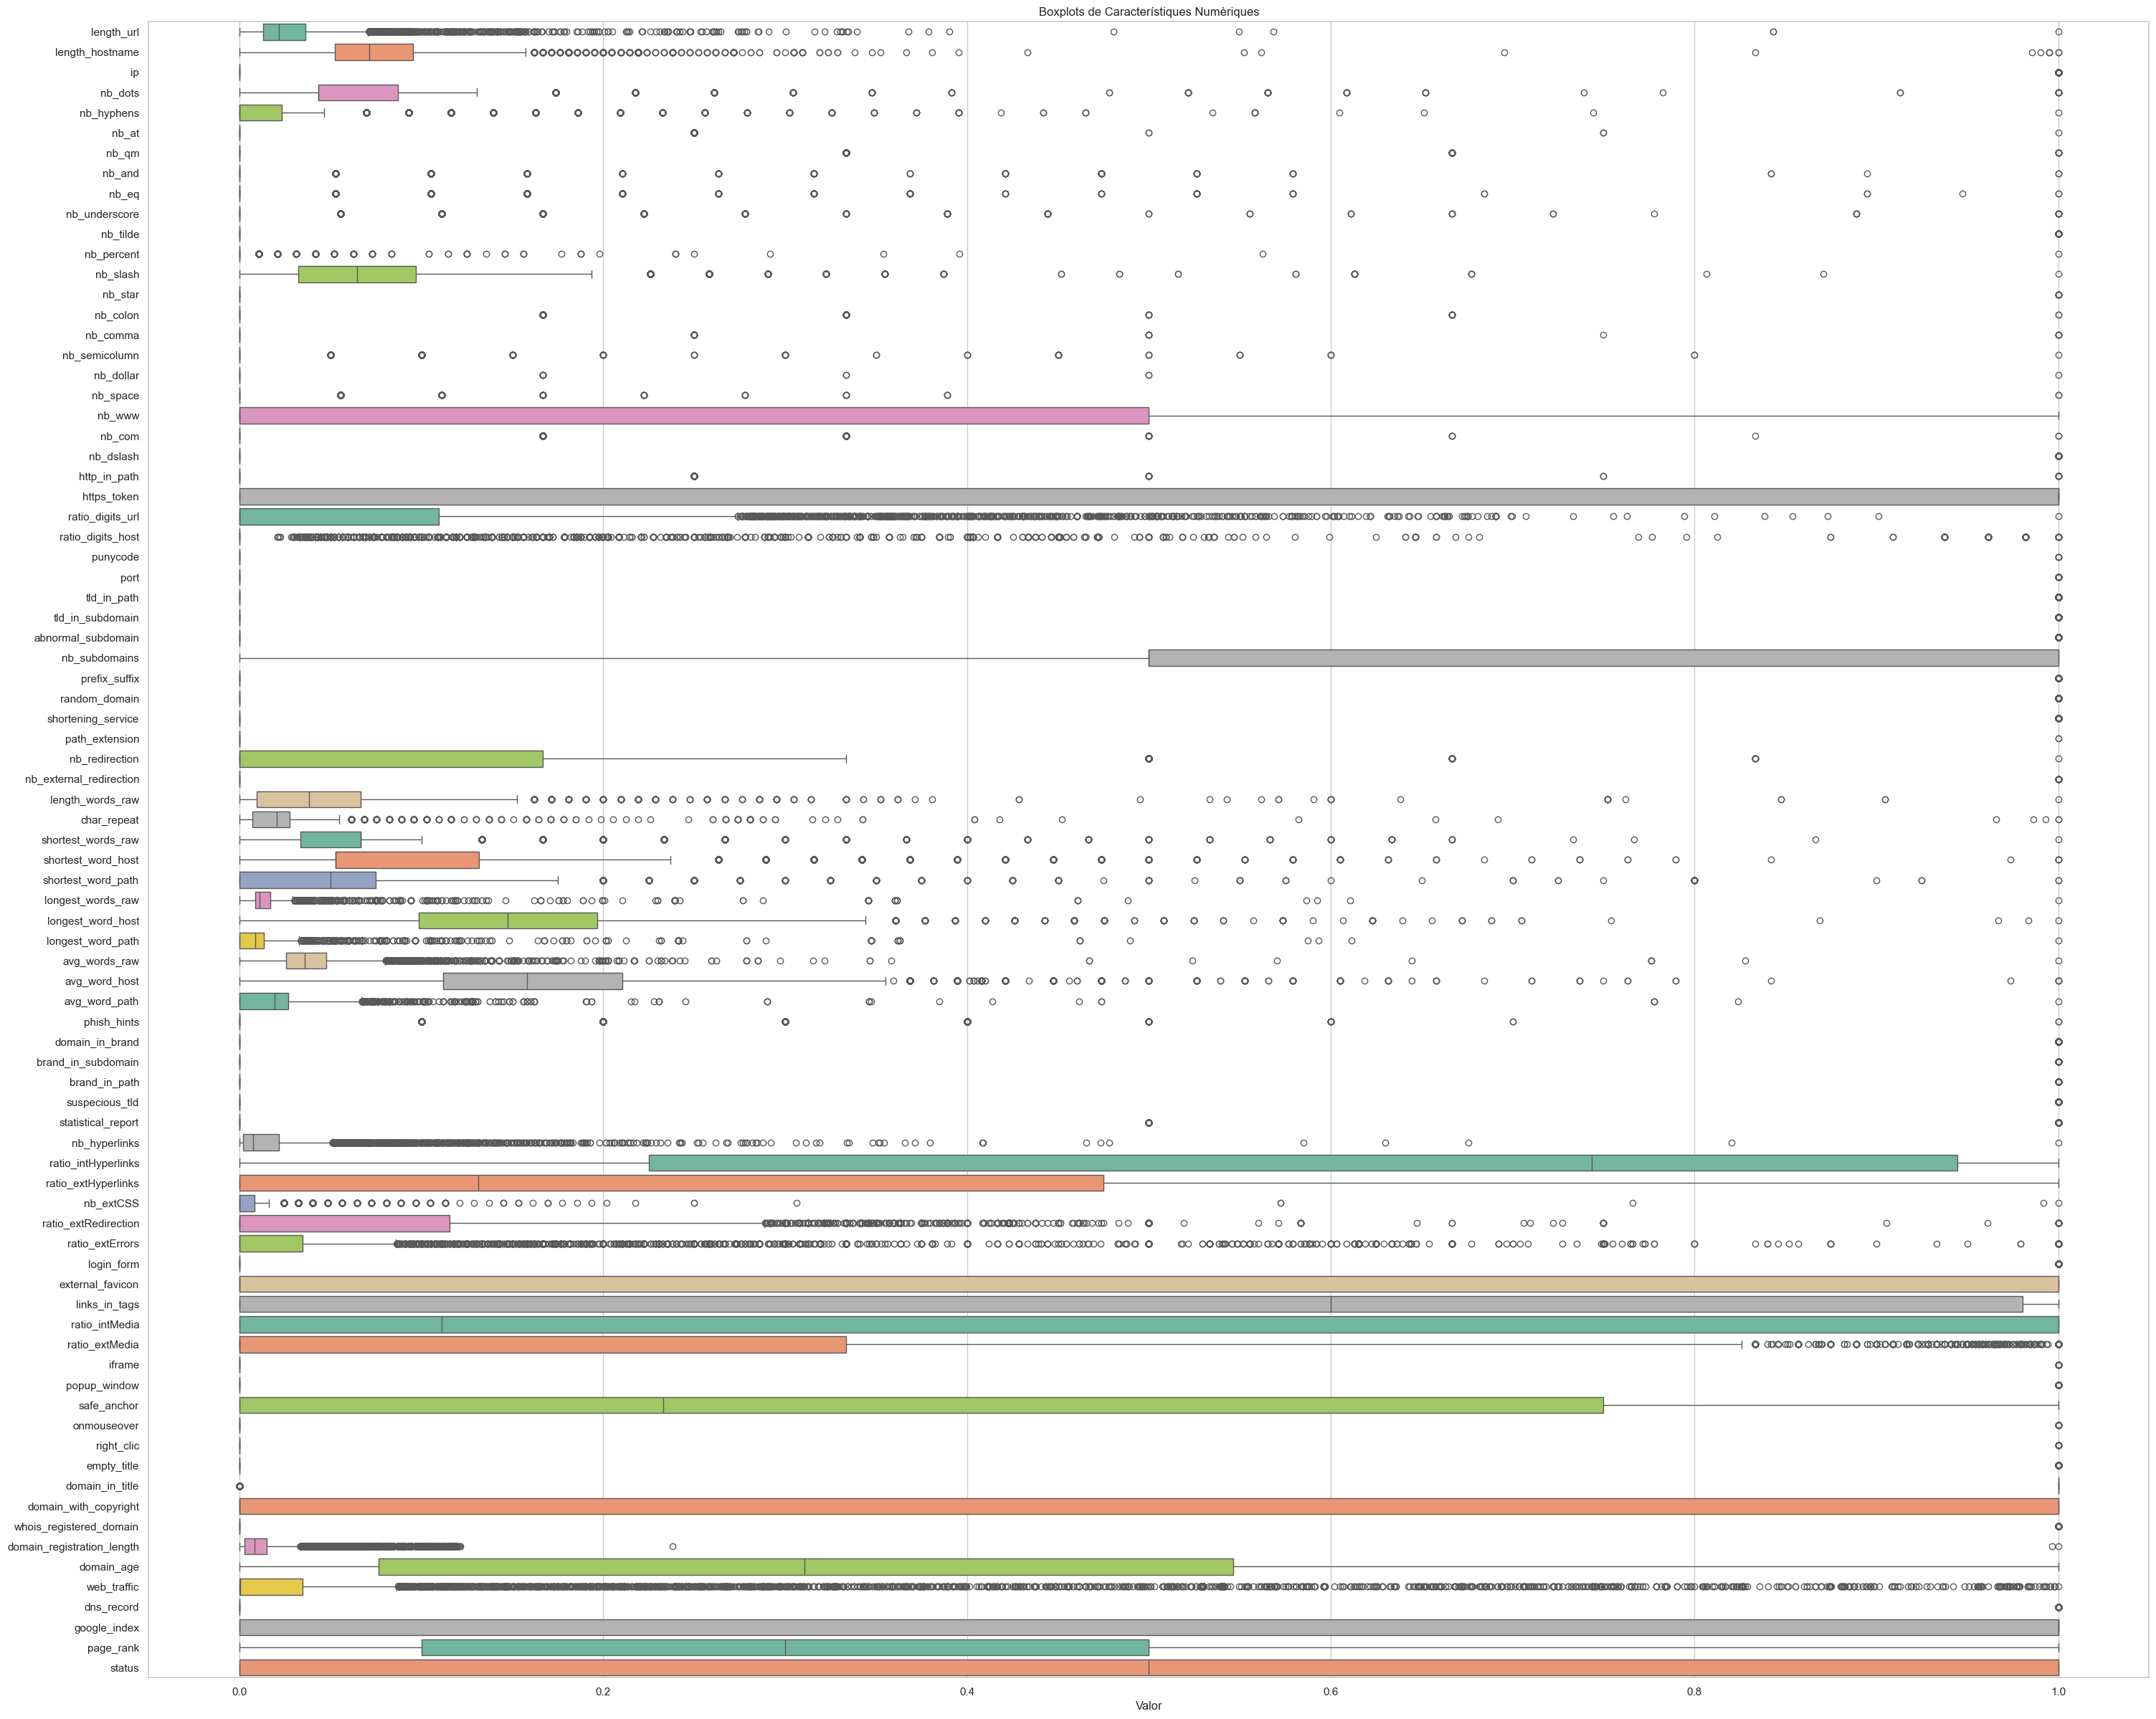

In [71]:
# Creació de gràfics de caixes més grans per a característiques numèriques
plt.figure(figsize=(36, 30)) 
sns.set(style="whitegrid")

# Seleccionem les característiques numèriques per als quals volem generar els boxplots
features_for_boxplot = data_preprocessada.select_dtypes(include=['int', 'float'])

# Dibuixem els gràfics de caixes
sns.boxplot(data=features_for_boxplot, orient="h", palette="Set2")
plt.title("Boxplots de Característiques Numèriques")
plt.xlabel("Valor")
plt.show()

##### <b>1.4.1 Histogrames</b>

Els histogrames mostren la distribució de les dades numèriques i ens permeten veure la forma de la distribució.

<b>· Dades originals</b>

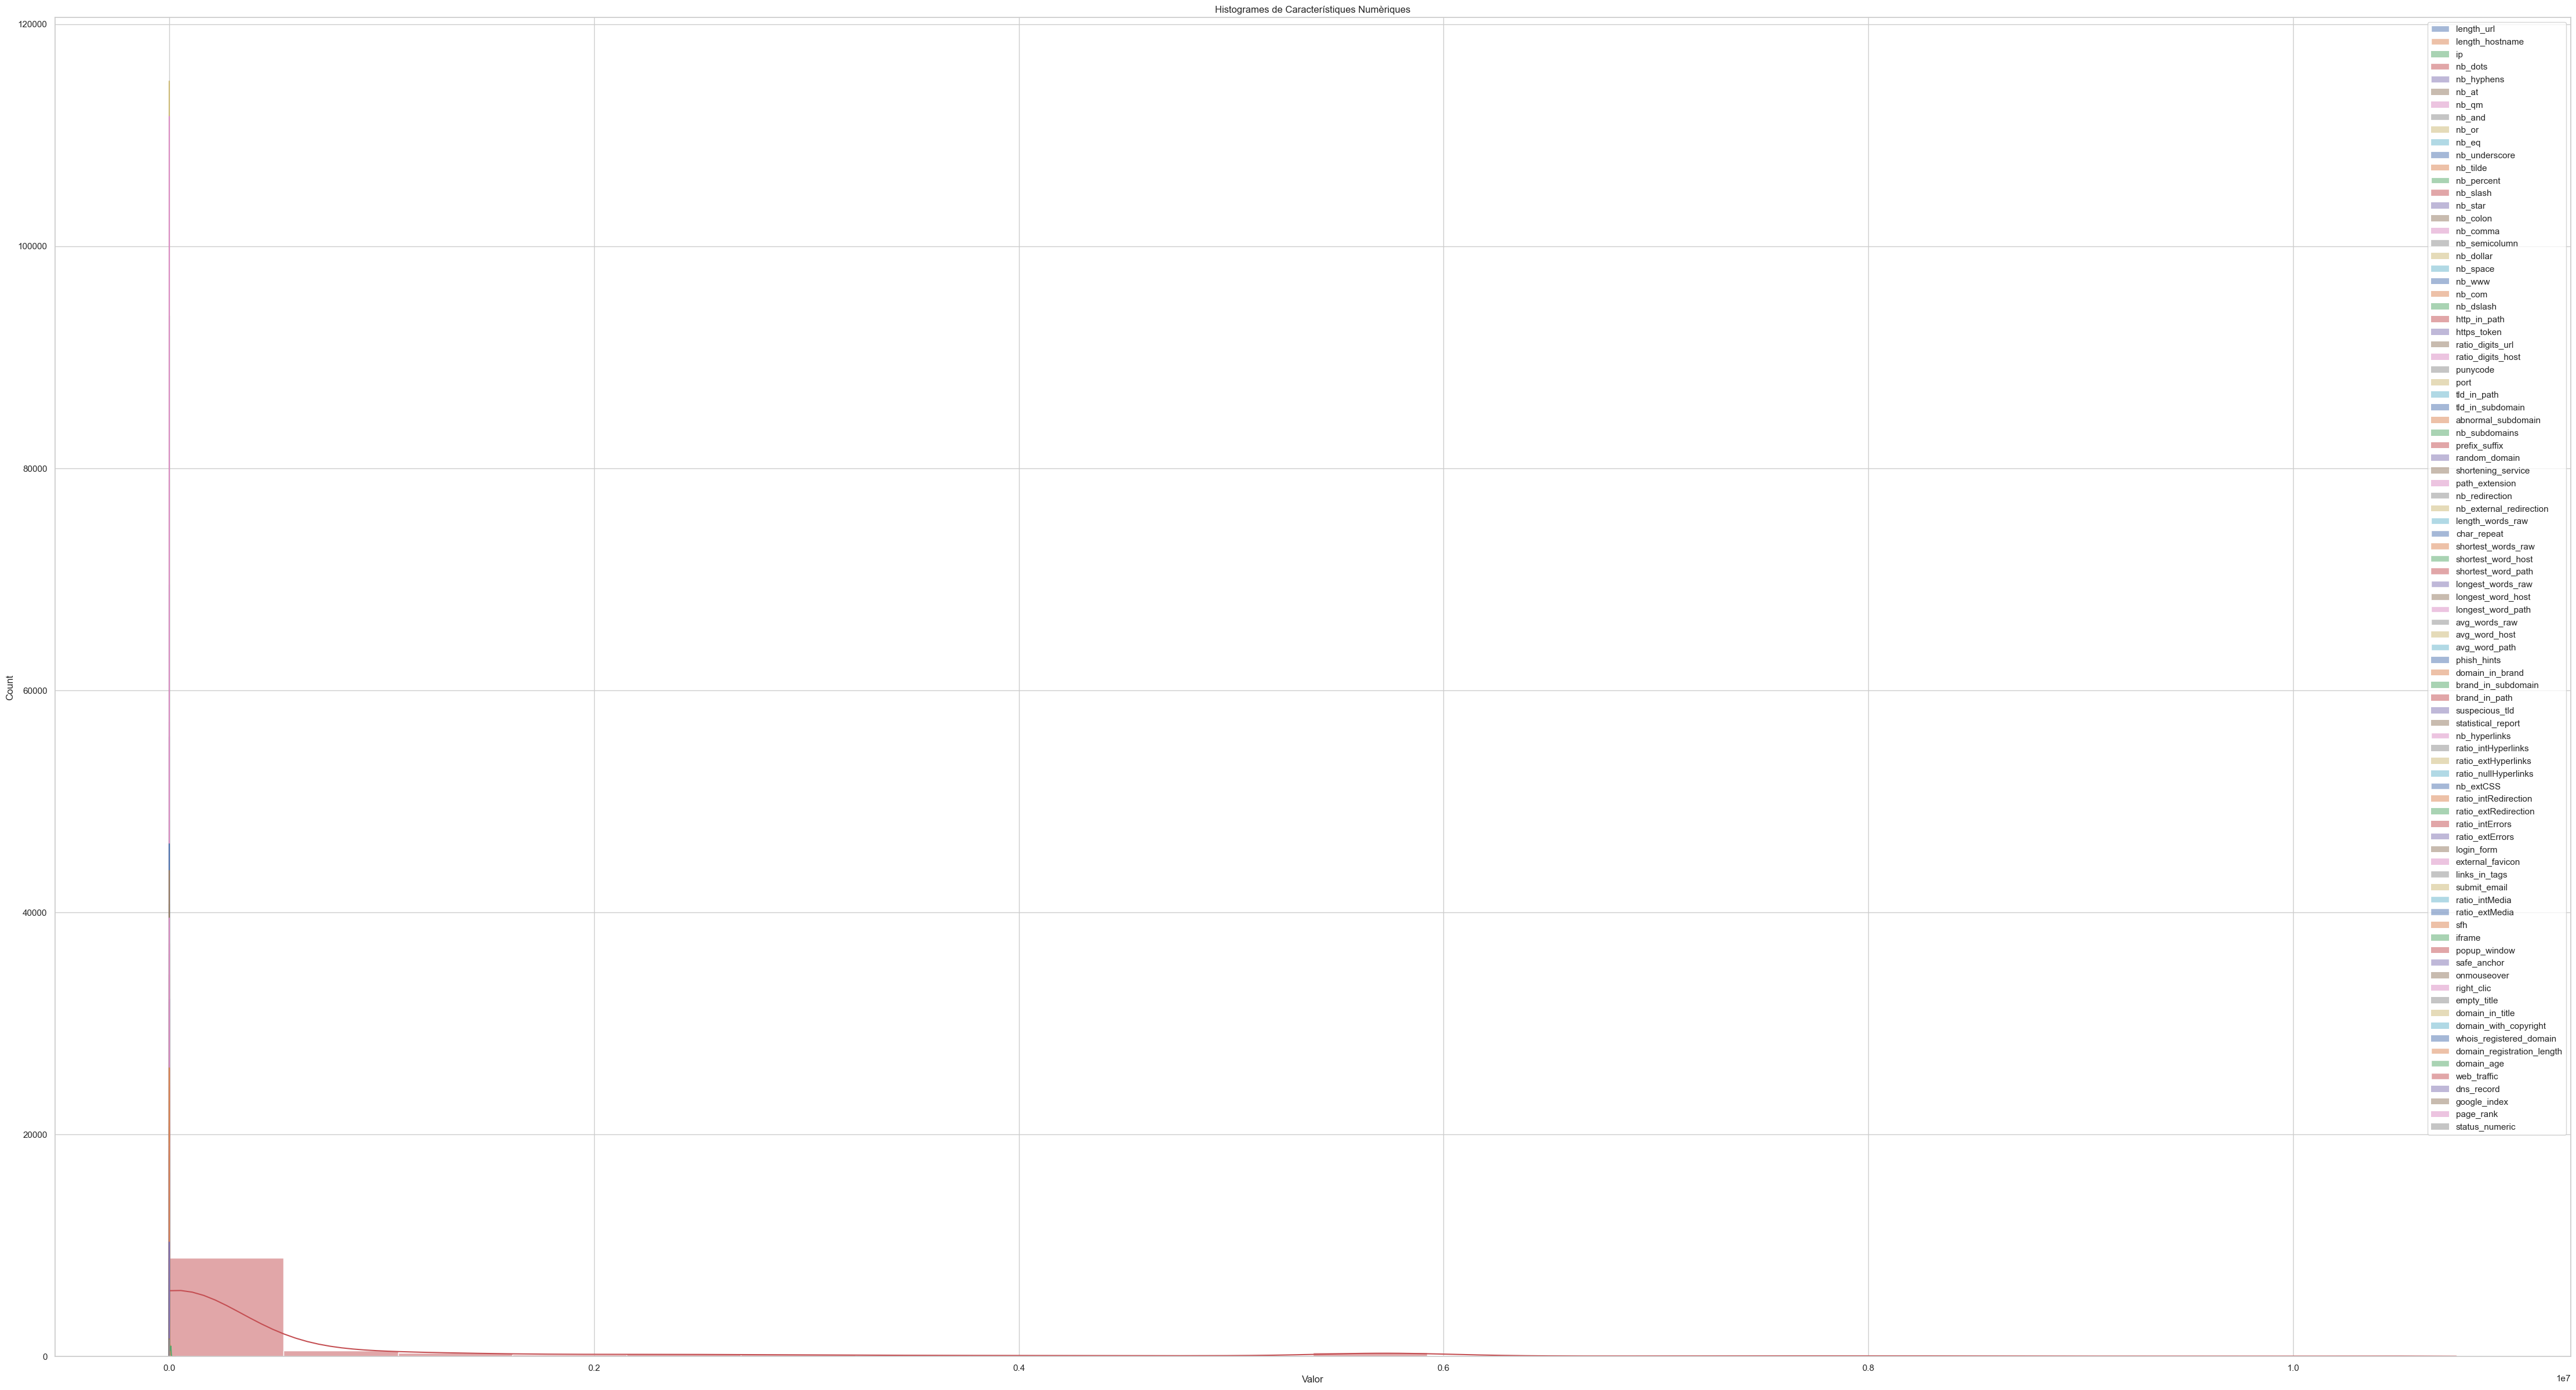

In [72]:
# Creació d'histogrames més grans per a característiques numèriques
plt.figure(figsize=(56, 30))  
sns.set(style="whitegrid")

# Seleccionem les característiques numèriques per als quals volem generar histogrames
features_for_histogram = data.select_dtypes(include=['int', 'float'])

# Dibuixem els histogrames
for feature in features_for_histogram.columns:
    sns.histplot(data[feature], kde=True, bins=20, label=feature)

plt.title("Histogrames de Característiques Numèriques")
plt.xlabel("Valor")
plt.legend()
plt.show()

<b>· Dades pre-processades</b>

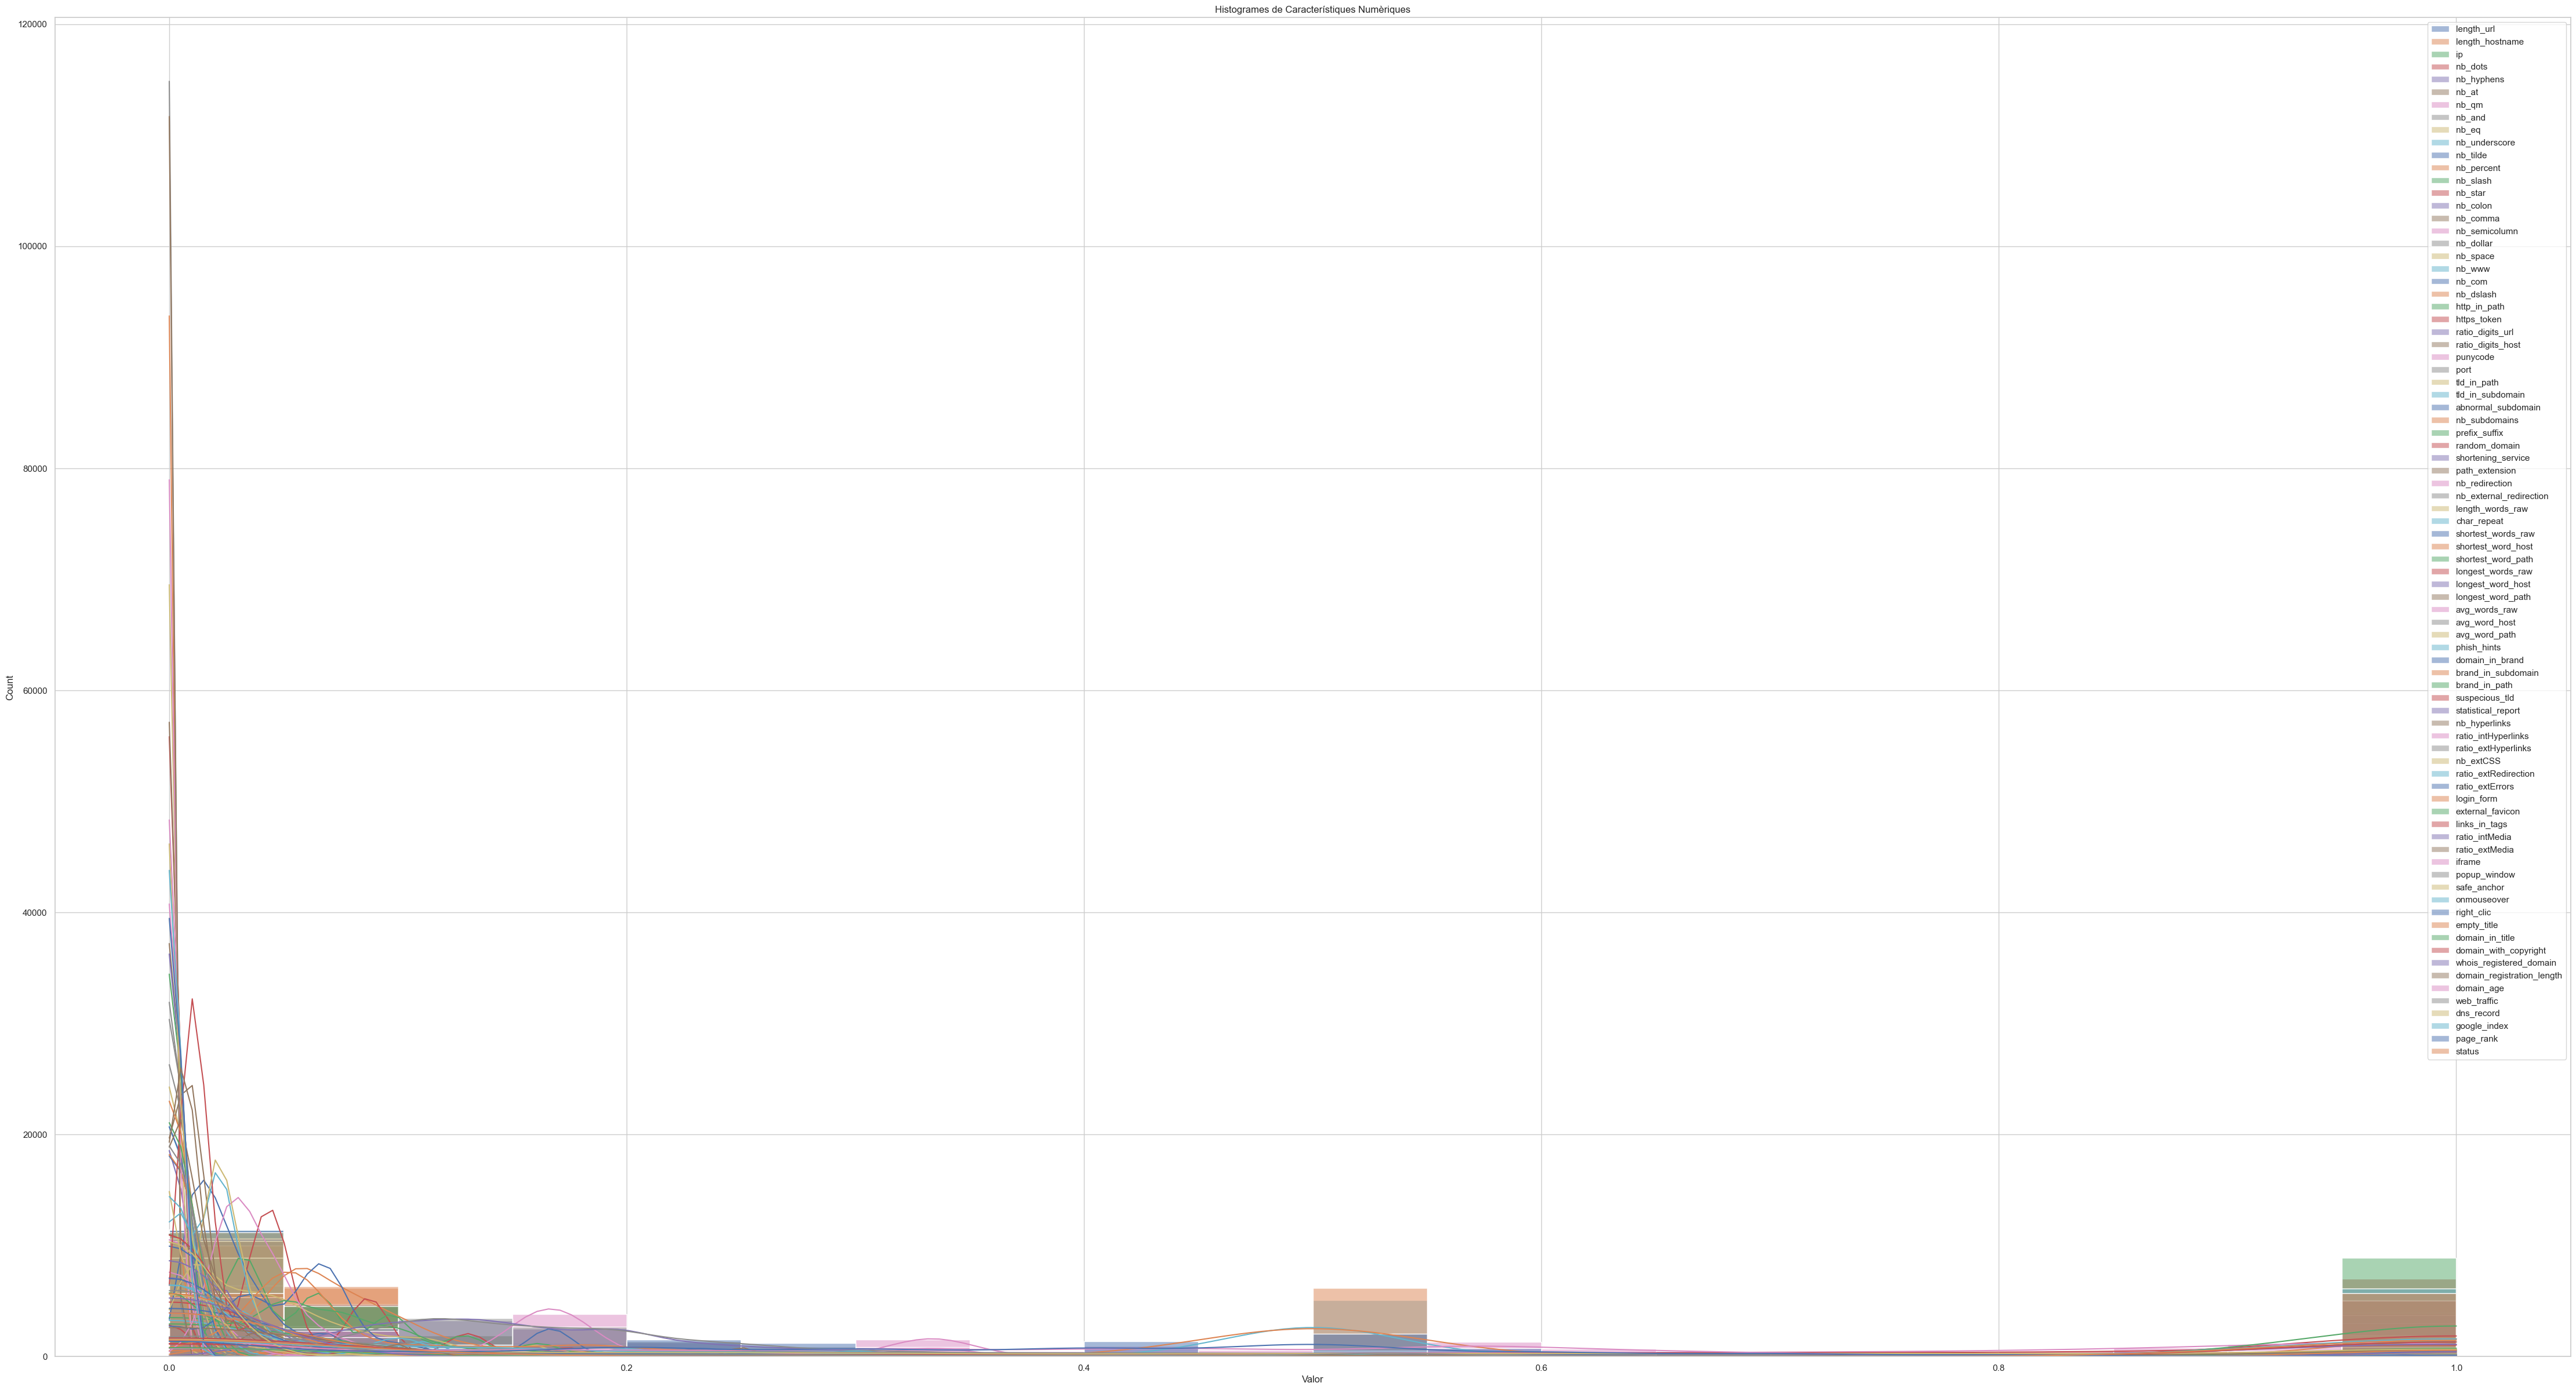

In [73]:
# Creació d'histogrames més grans per a característiques numèriques
plt.figure(figsize=(56, 30))  
sns.set(style="whitegrid")

# Seleccionem les característiques numèriques per als quals volem generar histogrames
features_for_histogram = data_preprocessada.select_dtypes(include=['int', 'float'])

# Dibuixem els histogrames
for feature in features_for_histogram.columns:
    sns.histplot(data_preprocessada[feature], kde=True, bins=20, label=feature)

plt.title("Histogrames de Característiques Numèriques")
plt.xlabel("Valor")
plt.legend()
plt.show()

#### <b>1.5 PCA (Principal Component Analysis)</b>

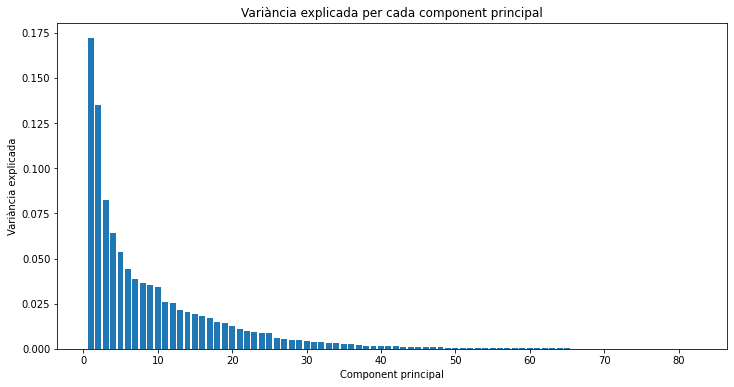

In [38]:
# Apliquem PCA
pca = PCA()
components = pca.fit_transform(data_preprocessada)

# Visualitzem la variància explicada per cada component principal
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Component principal')
plt.ylabel('Variància explicada')
plt.title('Variància explicada per cada component principal')
plt.show()


A partir de la visualització, podem fer les següents observacions:

    1. Declivi ràpid inicial: Les primeres components principals expliquen una quantitat significativa de la variabilitat de les dades, amb un declivi ràpid en la variància explicada a mesura que augmenta el número de components.
    
    2. Plateau després d'unes poques components: Després d'un cert número de components (aproximadament 10-15), la variància explicada per cada component addicional disminueix significativament, arribant a un plateau. Això indica que la major part de la informació està continguda en les primeres components.

Aquestes observacions suggerixen que podríem reduir la dimensió del conjunt de dades utilitzant només les primeres components principals sense perdre massa informació. Aquesta reducció podria ser útil per visualitzar les dades o per accelerar l'entrenament de models de machine learning.

A continuació, podem calcular la variància acumulada explicada per les components per determinar quantes d'elles s'haurien d'utilitzar per capturar una determinada quantitat de la variabilitat total (per exemple, el 95%).​

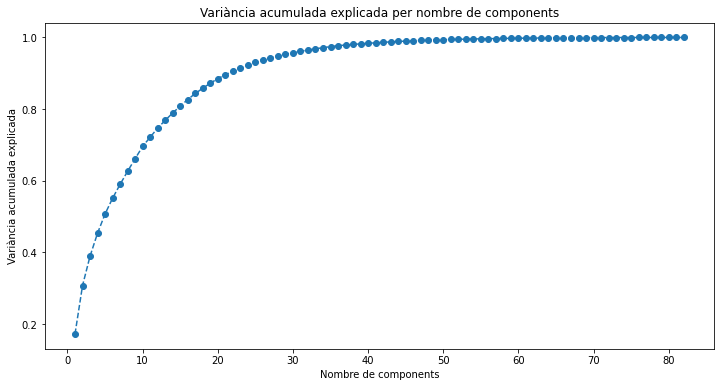

29

In [39]:
# Calculem la variància acumulada explicada
variancia_acumulada = pca.explained_variance_ratio_.cumsum()

# Visualitzem la variància acumulada
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
plt.xlabel('Nombre de components')
plt.ylabel('Variància acumulada explicada')
plt.title('Variància acumulada explicada per nombre de components')
plt.show()

# Determinem el nombre de components necessaris per explicar almenys el 95% de la variància
components_95_variancia = sum(variancia_acumulada < 0.95) + 1

components_95_variancia

La visualització mostra la variància acumulada explicada a mesura que augmentem el nombre de components principals. A partir d'aquesta, podem observar que:

    1. La variància acumulada augmenta ràpidament amb les primeres components i comença a estabilitzar-se a mesura que s'afegeixen més components.

    2. Per explicar almenys el 95% de la variància total de les dades, necessitaríem utilitzar 29 components principals.

In [40]:
# Reajustem el PCA amb 29 components
pca_29 = PCA(n_components=components_95_variancia)
data_reduida = pca_29.fit_transform(data_preprocessada)

# Mostrem les primeres files de la representació reduïda
data_reduida[:5]

array([[-0.44858827, -0.34988644, -0.00386875, -0.37177353,  0.12117681,
        -0.38584018,  0.55995848, -0.18844735,  0.58173634,  0.94192037,
         0.45144859, -0.04861221, -0.05918577, -0.13307994, -0.08888951,
         0.19386002,  0.09801483, -0.2571235 ,  0.20804318, -0.32767603,
         0.22575274,  0.07980403,  0.21017446, -0.47185551, -0.25655806,
         0.29967022,  0.09225409,  0.03471161, -0.23522889],
       [ 0.25669668, -1.18315932,  0.11864712,  0.0176455 , -0.63524817,
         0.17898941,  0.30886406,  0.50645507, -0.17667747, -0.39388182,
        -0.61666301,  0.30963627, -0.56757716, -0.02673276,  0.07861513,
        -0.00983817,  0.27002318, -0.00653426, -0.08178603, -0.18114856,
        -0.28897653, -0.06917565, -0.1672143 , -0.0666373 ,  0.11171052,
        -0.01818632, -0.02522992, -0.1988306 , -0.00646948],
       [ 0.55723092, -1.30716549,  0.33681913,  1.00540177,  0.02310384,
         1.10870913, -0.08958969, -0.31360431, -0.27298491, -0.41796011,
  

# 2. Criteris d'avaluació dels models de mineria de dades

Separar Característiques i Variable Objectiu

In [46]:
# Separació de les característiques i la variable objectiu
X = data_preprocessada.drop('status', axis=1)  # Eliminem la columna objectiu
y = data_preprocessada['status']  # La columna objectiu
print(X.shape)
print(y.shape)

(11430, 81)
(11430,)


Divisió en Conjunts d'Entrenament i Prova

In [48]:
# Divisió del conjunt de dades en entrenament i prova
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Configuració de Validació Creuada Estratificada

In [49]:
# Configuració de la validació creuada
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# 3. Execució de diferents models de Machine Learning

Verificar si hi ha alguna columna que estigui altament correlacionada amb la columna de etiquetes

#### <b>3.1 Naïve Bayes</b>

Inicialitzem un classificador Gaussian Naïve Bayes i emprem la cross-validation (amb StratifiedKFold) per avaluar el seu rendiment en el conjunt de dades complet. Obtenim una precisió mitjana (np.mean(cv_scores)) de 0.706, a través de les diferents particions de la cross-validation. 

In [43]:
from sklearn.naive_bayes import GaussianNB      
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.neighbors as nb

gnb = GaussianNB()
cv_scores = cross_val_score(gnb,X=X,y=y,cv=skf)
np.mean(cv_scores)

0.7069116360454942

Apliquem la funcio cross_val_predict per fer prediccions sobre tot el conjunt de dades utilitzant la mateixa estratègia de validació creuada. Les mètriques de confusió (confusion_matrix) i precisió (accuracy_score) han confirmat que el model ha tingut un rendiment perfecte, sense cap error de classificació.

In [44]:
cv_scores = cross_val_score(GaussianNB(), X, y, cv=skf, scoring='accuracy')
recall_scores = cross_val_score(GaussianNB(), X, y, cv=skf, scoring='recall')
f1_scores = cross_val_score(GaussianNB(), X, y, cv=skf, scoring='f1')

print(f"Accuracy mitjana: {np.mean(cv_scores)}")
print(f"Recall mitjana: {np.mean(recall_scores)}")
print(f"F1 mitjana: {np.mean(f1_scores)}")

Accuracy mitjana: 0.7069116360454942
Recall mitjana: 0.4435740266738516
F1 mitjana: 0.6019086503194943


#### <b>3.2 K-NN</b>

Normalitzem de les dades

In [16]:
# Crear l'objecte StandardScaler i escalar les dades d'entrenament
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Creem un pipeline que inclogui la normalització i el classificador K-NN

In [17]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

Definim una gamma de valors possibles per a k

In [18]:
k_range = range(1, 31)

Utilitzem GridSearchCV per trobar el millor valor de k

In [19]:
param_grid = {
    'knn__n_neighbors': k_range,
    # Tambe podem ajustar la mesura de distància amb 'knn__metric': ['euclidean', 'manhattan']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='accuracy')

# Entrenar utilitzant GridSearchCV
grid_search.fit(X_train, y_train)

# Millor valor de k
best_k = grid_search.best_params_['knn__n_neighbors']

print("Millor valor de k:", best_k)


Millor valor de k: 1


Visualitzem els resultats

In [ ]:
test_scores = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(12, 6))
plt.plot(k_range, test_scores, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

# Mostrar el millor valor de k i la seva precisió
print(f"Best K Value: {best_k}")
print(f"Best Accuracy: {grid_search.best_score_}")



Apliquem el model KNN amb la millor K trobada

In [21]:
# Crear el model KNN amb k=best_k
knn_model = KNeighborsClassifier(n_neighbors=best_k)

# Entrenar el model amb el conjunt d'entrenament
knn_model.fit(X_train_scaled, y_train)

# Fer prediccions en el conjunt de prova
y_pred = knn_model.predict(X_test_scaled)

# Avaluació del model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Mostrar els resultats
print("Precisió (Accuracy):", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Matriu de Confusió:\n", conf_matrix)
print("Informe de Classificació:\n", class_report)


Precisió (Accuracy): 0.9348206474190727
Recall: 0.9343832020997376
F1 Score: 0.9347921225382932
Matriu de Confusió:
 [[1069   74]
 [  75 1068]]
Informe de Classificació:
               precision    recall  f1-score   support

         0.0       0.93      0.94      0.93      1143
         1.0       0.94      0.93      0.93      1143

    accuracy                           0.93      2286
   macro avg       0.93      0.93      0.93      2286
weighted avg       0.93      0.93      0.93      2286



In [22]:
# Rang de K i mesures de distància
k_range = range(1, 31)
distance_metrics = ['euclidean', 'manhattan', 'minkowski']

# Configuració de la cerca en reixeta
param_grid = {
    'knn__n_neighbors': k_range,
    'knn__metric': distance_metrics
}

# Creació de la pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Configuració de múltiples mètriques d'avaluació
scoring = {'accuracy': 'accuracy', 
           'recall': make_scorer(recall_score, average='macro'), 
           'f1_score': make_scorer(f1_score, average='macro')}

grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring=scoring, refit='accuracy')

# Entrenament
grid_search.fit(X_train, y_train)

# Resultats
print("Millor combinació de paràmetres:", grid_search.best_params_)
print("Millor accuracy:", grid_search.best_score_)

# Per obtenir els millors resultats de recall i F1-score:
results = grid_search.cv_results_
print("Millor recall:", max(results['mean_test_recall']))
print("Millor F1-score:", max(results['mean_test_f1_score']))


Millor combinació de paràmetres: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7}
Millor precisió: 0.949911276918846
Millor recall: 0.9499097015852389
Millor F1-score: 0.949906006998782


hacer seleccion de caracteristicas para KNN

#### <b>3.3 Decision Trees</b>

Crear un arbre de decisió i definir un rang de paràmetres per ajustar

In [99]:
dt = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

Utilitzar GridSearchCV per trobar els millors paràmetres

In [100]:
grid_search_dt = GridSearchCV(dt, param_grid, cv=skf, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)

# Millors paràmetres trobats
best_params = grid_search_dt.best_params_

In [101]:
print(f"Best parameters: {best_params}")

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}


Entrenar l'arbre de decisió amb els millors paràmetres

In [102]:
best_dt = DecisionTreeClassifier(**best_params, random_state=42)
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=42)

Visualitzar l'arbre

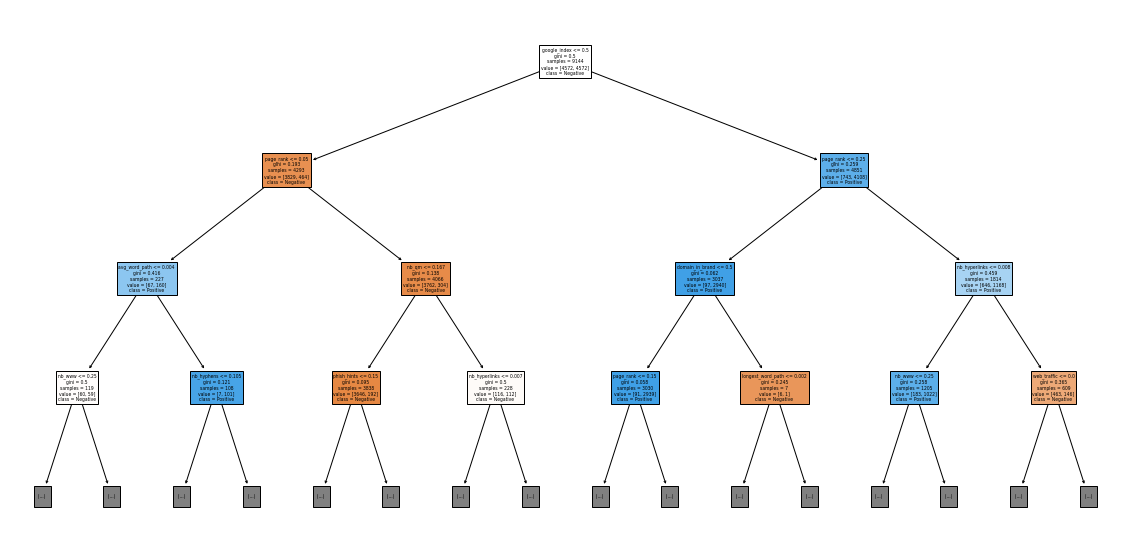

In [103]:
plt.figure(figsize=(20,10))
plot_tree(best_dt, filled=True, feature_names=X.columns.tolist(), class_names=['Negative', 'Positive'], max_depth=3)
plt.show()


Anàlisi de les fulles i regles més rellevants. Podrem obtenir informació de les fulles i les regles directament des de la visualització de l'arbre


In [104]:
# Evaluació de l'arbre en el conjunt de prova
y_pred_dt = best_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy_dt}")
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9374453193350831
Recall: 0.9343832020997376
F1 Score: 0.9347921225382932


Analisi de les regles mes rellevants y la barreja d'exemples en les fulles

In [ ]:
feature_names = X.columns.tolist()
n_nodes = best_dt.tree_.node_count
children_left = best_dt.tree_.children_left
children_right = best_dt.tree_.children_right
feature = best_dt.tree_.feature
threshold = best_dt.tree_.threshold

Recorregut per els nodes per obtenir les regles

In [ ]:
def get_rules(node, depth):
    if (children_left[node] != children_right[node]): # Si no es una hoja
        # Si hay una característica a comprobar en este nodo (no es una hoja)
        if feature[node] != -2:
            name = feature_names[feature[node]]
            threshold_value = threshold[node]
            print(f"{'|   ' * depth}If {name} <= {threshold_value:.2f}")
            get_rules(children_left[node], depth + 1)
            print(f"{'|   ' * depth}Else (if {name} > {threshold_value:.2f})")
            get_rules(children_right[node], depth + 1)
    else:
        print(f"{'|   ' * depth}Predicted class: {best_dt.classes_[np.argmax(best_dt.tree_.value[node])]} with probability {100.0 * np.max(best_dt.tree_.value[node]) / np.sum(best_dt.tree_.value[node]):.2f}%")


Tractament de les Regles obtingudes

In [ ]:
# Obtención de las reglas
print("Decision Tree Rules:")
get_rules(0, 0)

# Calcular la importancia de las características
importances = best_dt.feature_importances_
indices = np.argsort(importances)[::-1]

# Imprimir la importancia de las características
print("Feature importances:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})")

#### <b>3.4 Support Vector Machines</b>

Ajustament de Paràmetres amb GridSearchCV (Utilitzarem GridSearchCV per experimentar amb diferents tipus de nuclis (com ara lineal, polinòmic, i RBF) i altres paràmetres com C i gamma.)

In [24]:
# Defineix el model SVM
svm = SVC()

# Defineix el grid de paràmetres a provar
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# Crea el GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=skf, scoring='accuracy')

# Entrena el model
grid_search.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy')

Selecció i Avaluació del Millor Model

In [25]:
# Millor combinació de paràmetres
best_params = grid_search.best_params_
print("Millors paràmetres:", best_params)

# Crea el model amb els millors paràmetres
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Avaluació del model
y_pred = best_svm.predict(X_test)
print("Precisió (Accuracy):", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Millors paràmetres: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Precisió (Accuracy): 0.9553805774278216
Recall: 0.9562554680664916
F1 Score: 0.9554195804195804


Inspecció dels Vectors de Suport

In [158]:
# Nombre de vectors de suport
print("Nombre de vectors de suport:", len(best_svm.support_vectors_))

# Vectors de suport
print("Vectors de suport:\n", best_svm.support_vectors_)

Nombre de vectors de suport: 1369
Vectors de suport:
 [[0.053407   0.05714286 0.         ... 0.         1.         0.7       ]
 [0.00552486 0.03809524 0.         ... 0.         0.         0.2       ]
 [0.01411909 0.09047619 0.         ... 0.         0.         0.        ]
 ...
 [0.03806016 0.12380952 0.         ... 0.         1.         0.3       ]
 [0.0116636  0.08571429 0.         ... 0.         0.         0.5       ]
 [0.02946593 0.06666667 0.         ... 0.         0.         0.5       ]]


Mostrem resultats grafica 3D

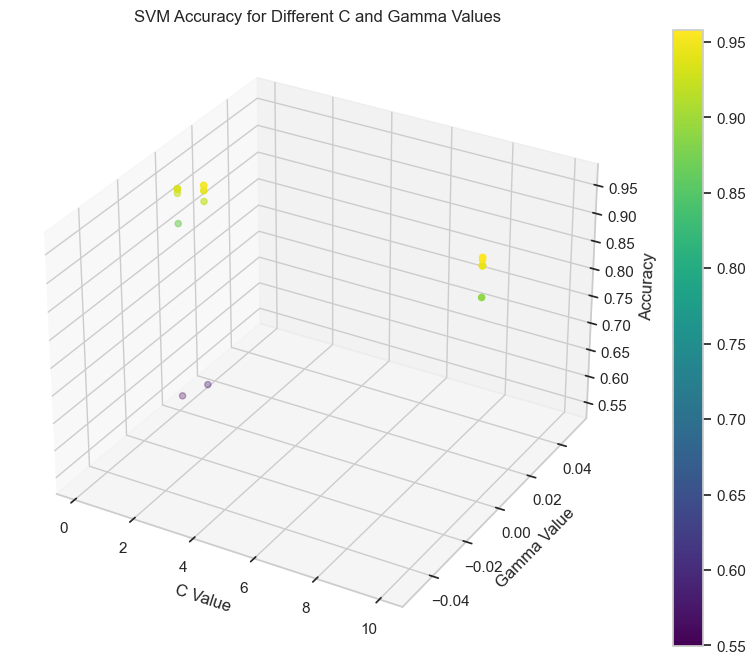

In [160]:
results = grid_search.cv_results_
C_values = results['param_C']
gamma_values = results['param_gamma']
scores = results['mean_test_score']

# Assegura't que C_values i gamma_values siguin numèrics
C_numeric = [float(c) for c in C_values]
gamma_numeric = [float(g) if g != 'scale' and g != 'auto' else 0 for g in gamma_values]  # Suposem 0 per a 'scale' i 'auto'

# Crear la figura i l'eix 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Crear un gràfic de dispersió 3D
scat = ax.scatter(C_numeric, gamma_numeric, scores, c=scores, cmap='viridis')

# Afegir títol i etiquetes
ax.set_title('SVM Accuracy for Different C and Gamma Values')
ax.set_xlabel('C Value')
ax.set_ylabel('Gamma Value')
ax.set_zlabel('Accuracy')

# Afegir una barra de color
plt.colorbar(scat)

# Mostrar la gràfica
plt.show()


#### <b>3.5 Meta-learning algorithms</b>

#### <b>3.5.1 Majority Voting</b>

Definir els models individuals

In [33]:
model1 = DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=42)
model2 = KNeighborsClassifier(n_neighbors=1)
model3 = SVC(C=10, kernel='rbf', gamma='scale')

Crear un sistema d'ensemble utilitzant Majority Voting

In [34]:
ensemble = VotingClassifier(estimators=[
    ('dt', model1), 
    ('knn', model2), 
    ('svc', model3)
], voting='hard')

Avaluació del model

In [38]:
cv_scores = cross_val_score(ensemble, X, y, cv=skf, scoring='accuracy')
recall_scores = cross_val_score(ensemble, X, y, cv=skf, scoring='recall')
f1_scores = cross_val_score(ensemble, X, y, cv=skf, scoring='f1')

print(f"Accuracy mitjana: {np.mean(cv_scores)}")
print(f"Recall mitjana: {np.mean(recall_scores)}")
print(f"F1 mitjana: {np.mean(f1_scores)}")

Accuracy mitjana: 0.9587926509186351
Recall mitjana: 0.9559018039753593
F1 mitjana: 0.9586757266143173


#### <b>3.5.2 Bagging</b>

Model base: Arbre de Decisió


In [61]:
base_estimator = DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=42)

Creació del Bagging Classifier

In [64]:
bagging_model = BaggingClassifier(base_estimator=base_estimator, n_estimators=100, random_state=42)

Entrenament i validació amb cross-validation

In [65]:
cv_scores = cross_val_score(bagging_model, X, y, cv=skf, scoring='accuracy')
recall_scores = cross_val_score(bagging_model, X, y, cv=skf, scoring='recall')
f1_scores = cross_val_score(bagging_model, X, y, cv=skf, scoring='f1')

print(f"Accuracy mitjana: {np.mean(cv_scores)}")
print(f"Recall mitjana: {np.mean(recall_scores)}")
print(f"F1 mitjana: {np.mean(f1_scores)}")

Accuracy mitjana: 0.9544181977252844
Recall mitjana: 0.9534536391804342
F1 mitjana: 0.9543724560275659


#### <b>3.5.3 Random Forest</b>

Creació i Entrenament del Model de Random Forest

In [67]:
# Creació del model de Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

Avaluació del Model

In [68]:
# Avaluació del model utilitzant precisió, recuperació i puntuació F1
precision = cross_val_score(rf_classifier, X_train, y_train, cv=skf, scoring='precision')
recall = cross_val_score(rf_classifier, X_train, y_train, cv=skf, scoring='recall')
f1_score = cross_val_score(rf_classifier, X_train, y_train, cv=skf, scoring='f1')

print(f'Precisió mitjana: {precision.mean()}')
print(f'Recuperació mitjana: {recall.mean()}')
print(f'Puntuació F1 mitjana: {f1_score.mean()}')

Precisió mitjana: 0.9676620741335663
Recuperació mitjana: 0.966531776442147
Puntuació F1 mitjana: 0.9670604452108753


Visualització gràfica dels resultats

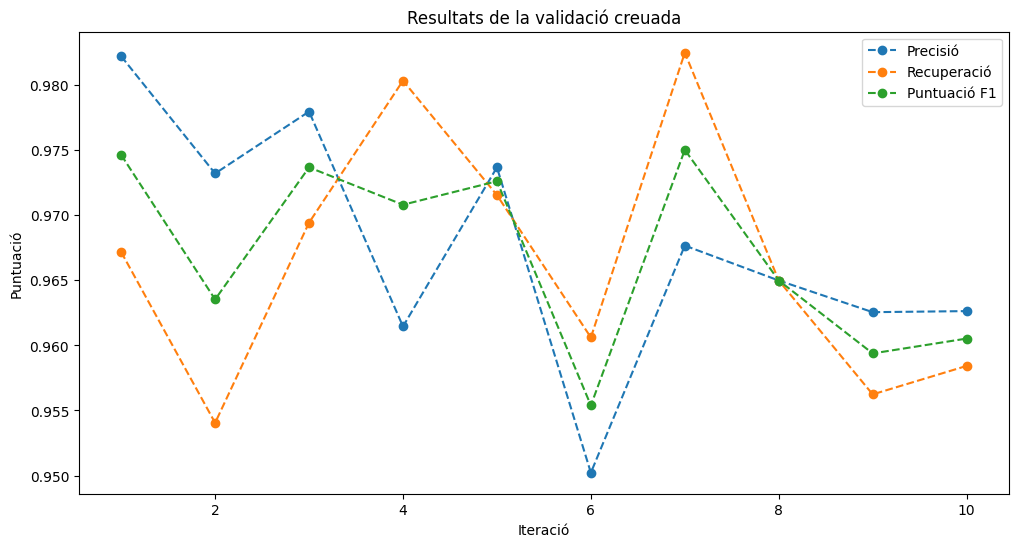

In [69]:
# Visualitzacó dels resultats
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), precision, marker='o', linestyle='--', label='Precisió')
plt.plot(range(1, 11), recall, marker='o', linestyle='--', label='Recuperació')
plt.plot(range(1, 11), f1_score, marker='o', linestyle='--', label='Puntuació F1')
plt.xlabel('Iteració')
plt.ylabel('Puntuació')
plt.title('Resultats de la validació creuada')
plt.legend()
plt.show()


#### <b>3.5.4 Adaboost</b>

Definir l'arbre de decisió com a estimador base

In [81]:
base_estimator = DecisionTreeClassifier(random_state=42)

Crear el model AdaBoost

In [82]:
ada_boost_model = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)

Definir els paràmetres per la recerca en quadrícula

In [83]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'base_estimator__max_depth': [1, 2, 3]
}

Utilitzar GridSearchCV per trobar els millors paràmetres

In [84]:
grid_search = GridSearchCV(ada_boost_model, param_grid, cv=skf, scoring='accuracy')
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                                          random_state=42),
             param_grid={'base_estimator__max_depth': [1, 2, 3],
                         'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

Millors paràmetres i millor puntuació

In [85]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Millors paràmetres:", best_params)
print("Millor puntuació (Accuracy):", best_score)

Millors paràmetres: {'base_estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200}
Millor puntuació (Accuracy): 0.9631671041119858


Crear el model AdaBoost amb els millors paràmetres

In [86]:
best_ada_boost_model = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=best_params['base_estimator__max_depth'], random_state=42),
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    random_state=42
)

Entrenament i avaluació del model

In [87]:
best_ada_boost_model.fit(X_train, y_train)

y_pred = best_ada_boost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precisió (Accuracy):", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)


Precisió (Accuracy): 0.9575678040244969
Recall: 0.9658792650918635
F1 Score: 0.9579175704989155
